# Breast Cancer Classification Model

## Problem Definition

The Breast Cancer is a universal major health issue which could be improved with early diagnosis which could potentially lead to a more effective treatment plan. 
Our objective is to develop a machine learning model that can accurately classify a breast tumor as either benign or malignant. This classification will be based on different features extracted from digitized images of a breast mass.


## Data Exploration

### Wisconsin Diagnostic Breast Cancer Dataset

The Wisconsin Diagnostic Breast Cancer dataset describes the measurements on cells in suspicious lumps in a women's breast. This dataset, obtained from the University of Wisconsin Hospitals, includes 30 feature variables and 1 target variable. 

The features, or input attributes, are numeric, and a binary target variable: M for Malignant and B for benign.

Each cell-nucleus include 10 actual features:

- Radius (mean of distances from center to points on the perimeter)
- Texture (standard deviation of gray-scale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness (perimeter^2 / area - 1.0)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry 
- Fractal dimension ("coastline approximation" - 1)

Now, we will load the dataset so we can check the data in detail. To do so, we'll install the required libraries and packages.

We will to activate a virtual environment which will be helpful in isolating dependencies and avoid conflicts.

In [ ]:
!python -m venv myenv
!.\myenv\Scripts\activate
!code .

We need to switch the Jupyter Notebook Kernel to the newly created environment using the Jupyter Notebook interface and then install all the required libraries

In [ ]:
!pip3 install ipykernel matplotlib pandas numpy seaborn scikit-learn tensorflow scikeras

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

data_combined = pd.concat([X, y], axis=1)
  
# metadata 
#print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
#print(breast_cancer_wisconsin_diagnostic.variables)



### Checking the data

We'll retrieve a data preview of the data so we can have a first look at it.

In [ ]:
# Print the first few rows of the data
print("\nFirst few rows of Features and Target combined")
print(data_combined.head())

### The dimensionality of the dataset

We can see that we're able to access the repository from UCIML and the data is loaded. Now we need to understand the dimensionality of the dataset in terms of number of rows, columns (features and target variable).

In [ ]:
# Print the shape of the data

print("Shape of X (features):", X.shape)
print("Shape of y (targets):", y.shape)

### Statistical Summary

Let's retrieve the statistical properties of each attribute in order to get some insights.

In [ ]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

descriptionDataCombined = data_combined.describe()

print(descriptionDataCombined)

### Class Distribution

As this is a classification problem, we need to analyse the data in order to check how many observations do we have for each class. If they are highly imbalanced, then we'll need to take further actions in the data pre-processing.

In [ ]:
class_counts = data_combined.groupby('Diagnosis').size()
print(class_counts)

total = class_counts.sum()
proportion_B = class_counts['B'] / total
proportion_M = class_counts['M'] / total

print(f"\nProportion of class B: {proportion_B:.2f}")
print(f"Proportion of class M: {proportion_M:.2f}")

### Features Correlation 

By calculating the correlation between the different variables we'll be able to analyse if they are tightly coupled (highly correlated). This is important as it can affect the performance of the machine learning algorithms.

Let's calculate the Pearson's Correlation Coefficient, assuming that we have a normal distribution in the attributes. Before that, we need to convert the target variable to a numeric one.

In [ ]:
# Convert the Diagnosis column from string to numerical values.
data_combined['Diagnosis'] = data_combined['Diagnosis'].map({'M': 1, 'B': 0})

# Calculate the Pearson's Correlation Coefficient
correlations = data_combined.corr(method='pearson')
print(correlations)

As the table size is big, let's retrieve those variables that are highly correlated (> 0.75) by sorting and printing them.

In [ ]:
# Unstack the correlation matrix
correlation_pairs = correlations.unstack()

# Sort the correlation pairs
sorted_pairs = correlation_pairs.sort_values(kind="quicksort", ascending=False)

# Retrieve high correlations and exclude self-correlations, as they aren't relevant.
high_correlations = sorted_pairs[(sorted_pairs != 1.0) & (sorted_pairs.abs() > 0.75)]

print(high_correlations)

Let's plot a correlation matrix to achieve a better understanding of the data correlation

Datasource: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [ ]:
# Plotting the Correlation Matrix

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.index)), correlations.index)
plt.show()

We can see that the highly correlated variables are the radius and perimeter. This makes sense due to its mathematical relationship, as the radius is directly proportional to the perimeter.

### Skew of Univariate Distributions

Now we'll check if there is any attribute with a skew, in order to consider it during our data preparation phase.

In [ ]:
skew = data_combined.skew()

sorted_skew = skew.sort_values(ascending=False)

negative_skew = sorted_skew[sorted_skew < 0]
positive_skew = sorted_skew[sorted_skew > 0]
higher_skew = sorted_skew[sorted_skew > 1]

print("\nNegative Skew\n")
print(negative_skew)

print("\nPositive Skew\n")
print(positive_skew)

print("\nHigher Skew\n")
print(higher_skew)

The skew result shows there is no negative skew as all attribute values are positive. 
Additionally, we can see that some features have a higher skew than the rest of the features as they are greater than 3.
Now, we'll plot the histograms of each attribute in order to check the distribution of each of them.

In [ ]:
# Univariate Histograms
data_combined.hist(figsize=[20, 20])
plt.show()

## Data Transformation

We don't see the need of any major rescaling or transformation in the data. What is needed, is to transform the target column, as it isn't numeric.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y.squeeze())

# Print the transformed target variable to check if we have transformed it correctly
print("Transformed Target Variables (First 10 elements):", y_numeric[:10])

## Feature Selection

### Principal Component Analysis (PCA)

As a preprocessing step, and in order to exclude irrelevant or redundant features, we will carry out a dimensionality reduction using the PCA technique. This will allow us to capture the maximum variance in our dataset with a fewer number of components.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Check the shape of the transformed data
print("Shape of X_pca:", X_pca.shape)

# Print the explained variance ratio of each principal component
print("Explained variance ratio of each principal component:")
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Principal Component {i+1}: {variance_ratio:.4f}")

# Print the total explained variance
total_explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance: {total_explained_variance:.4f}")

We see that the Principal Components 1 and 2 have a significantly higher variance ratios than the rest so which make them more important in capturing the variance of our dataset.

## Resampling

Since we already have the transformed dataset with the two selected components stored in the variable X_PCA, we will perform the resampling method K-Fold Cross-Validation to know how well the different models perform with data that haven´t been used to train them.

### Model Performance Estimation

We want to compare and select the best model based on its performance estimation across multiple folds.

We'll estimate the performance of 3 different machine learning algorithms using the K-Fold Cross-Validation:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Machine
- k-Nearest Neighbors
- Neural Network



Logistic Regression: 0.980702 (0.014573)
Decission Tree Classifier: 0.931516 (0.049237)
Random Tree Classifier: 0.948997 (0.025461)
Support Vector Machine: 0.971867 (0.016108)
k-Nearest Neighbors: 0.963158 (0.022807)


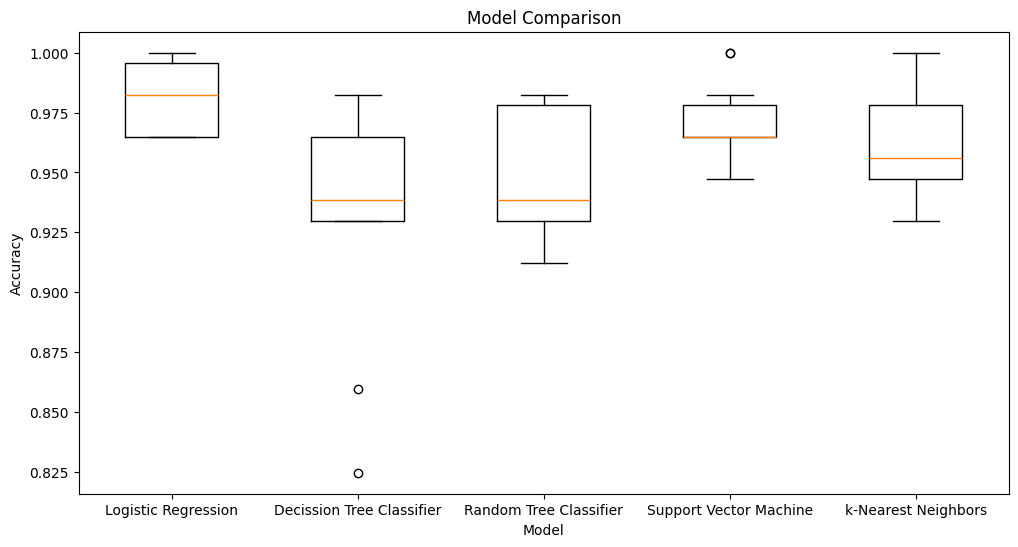

In [23]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

num_folds = 10
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear')))
models.append(('Decission Tree Classifier', DecisionTreeClassifier()))
models.append(('Random Tree Classifier', RandomForestClassifier()))
models.append(('Support Vector Machine', SVC()))
models.append(('k-Nearest Neighbors', KNeighborsClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 7 

for name, model in models:
   kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
   cv_results = cross_val_score(model, X_pca, y_numeric, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   print(msg)

# Plot the results
plt.figure(figsize=(12, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l2

import os
import warnings

# Suppress all UserWarnings to improve readability
warnings.filterwarnings('ignore', category=UserWarning)

# Environment setting for tf.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Define a function to create the different Keras models
def create_model_1():
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu'))  # input_dim should be 10
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added dropout layers to prevent overfitting
def create_model_2():
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu'))  # input_dim should be 10
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Added l2 regularization and dropout layers to prevent overfitting
def create_model_3():
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(10, activation='relu',kernel_regularizer=l2(0.01))) # Added l2 regularization
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

neural_network_models = []
neural_network_models.append(('Neural Network Model 1', KerasClassifier(build_fn=create_model_1, epochs=150, batch_size=10, verbose=0)))
neural_network_models.append(('Neural Network Model 2', KerasClassifier(build_fn=create_model_2, epochs=150, batch_size=10, verbose=0)))
neural_network_models.append(('Neural Network Model 3', KerasClassifier(build_fn=create_model_3, epochs=150, batch_size=10, verbose=0)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed = 7 

for name, model in neural_network_models:
   kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
   cv_results = cross_val_score(model, X_pca, y_numeric, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   print(msg)

# Plot the results
plt.figure(figsize=(12, 6))
plt.boxplot(results, tick_labels=names)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

After adding additional layers and dropout layers, the accuracy of the neural network model has improved. The accuracy of the neural network model is now comparable to the other models, such as Logistic Regression, Decision Tree Classifier, Random Forest Classifier, Support Vector Machine, and k-Nearest Neighbors. The neural network model achieved an accuracy of approximately 0.98, which is similar to the accuracy achieved by the other models. This indicates that the neural network model is performing well on the breast cancer dataset.

We observe some overfitting in the last model, as it performs better than the previous two models. This conclusion comes from independent testing, which shows a slight reduction in performance. However we won't investigate further but it can be attributed to random variations due to how the cross-validation splits the data.